<a href="https://colab.research.google.com/github/yusufprasatya/SentimentAnalysisOfIndonesia-sGovermentEfficiency/blob/main/Sentiment_Analysis_Goverment's_Efficiency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install Sastrawi
!pip install swifter
!pip install transformers torch pandas numpy datasets

In [5]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [4]:
# importing library
import tweepy
import pandas as pd
import re
import datetime
import time
import pandas as pd
import numpy as np
import re
import nltk
import string
import swifter
import matplotlib.pyplot as plt
import glob
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import plotly.express as px
import torch

In [ ]:
# Bearer token
bearer_token = "AAAAAAAAAAAAAAAAAAAAADwzzQEAAAAATPRpJa76BwznIgEiy61pTB6pHew%3DQz2yqeFGHzRr5hRzijtULvhPZknFdPn2cUxJzLUUOeQ6fdaTjL"

# Initialize API Client
client = tweepy.Client(bearer_token=bearer_token, wait_on_rate_limit=True)

# Example: Fetch recent tweets containing "efisiensi" excluding retweets
query = "Efisiensi -is:retweet"

# Fetch tweets
tweets = client.search_recent_tweets(query=query, max_results=100, tweet_fields=["created_at"], expansions=["author_id"], user_fields=["username"])

# Get user details from includes
user_dict = {user["id"]: user["username"] for user in tweets.includes["users"]}

# Initialize DataFrame
columns = ['User', 'Tweet', 'Tanggal tweet']
data = []

# Loop through tweets
for tweet in tweets.data:
    username = user_dict.get(tweet.author_id, "Unknown")
    data.append([username, tweet.text, tweet.created_at])
    print(tweet.text)

# Create DataFrame
df = pd.DataFrame(data, columns=columns)

# Print DataFrame
print(df)

In [ ]:
# covert datafram to csv
df.to_csv('data-crawling/efisiensi20252-10.csv', index=False)

# Data Preprocessing

In [8]:
csv_files = glob.glob("Data/*.csv")

# Read and combine all CSV files
df_list = [pd.read_csv(file) for file in csv_files]
combined_df = pd.concat(df_list, ignore_index=True)

# Display the first few rows
combined_df

,User,Tweet,Tanggal tweet
0,bibubbby,habis beli salad langganan tapi isinya ga penu...,2025-02-15 13:54:02+00:00
1,eyditye,Nanti kalo ada efisiensi lagi gausah diteriaki...,2025-02-15 13:53:56+00:00
2,esevce,Jepang efisiensi Viral video doodstream indo p...,2025-02-15 13:52:54+00:00
3,imannizal,Pertamina makin serius dorong energi bersih! K...,2025-02-15 13:52:48+00:00
4,bejes437951,"@detikcom Yah, rakyat dilupakan.. makanya prio...",2025-02-15 13:52:11+00:00
...,...,...,...
1095,detikTravel,Video: Permintaan Tiket Penerbangan Turun Imba...,2025-02-15 06:22:44+00:00
1096,Mutmutiaraw,"Pemerintah tau ni, kebijakannya jahat atau aka...",2025-02-15 06:12:42+00:00
1097,DPP_PKB,Legislator PKB @idafauziyah menegaskan bahwa e...,2025-02-15 06:07:02+00:00
1098,Mel612Bangka,Kebijakan Pemerintah untuk melakukan efisiensi...,2025-02-15 06:05:34+00:00


In [9]:
df = pd.DataFrame(combined_df[['Tweet']])

# Remove duplicates
df_cleaned = df.drop_duplicates()

print(df_cleaned)

                                                  Tweet
0     habis beli salad langganan tapi isinya ga penu...
1     Nanti kalo ada efisiensi lagi gausah diteriaki...
2     Jepang efisiensi Viral video doodstream indo p...
3     Pertamina makin serius dorong energi bersih! K...
4     @detikcom Yah, rakyat dilupakan.. makanya prio...
...                                                 ...
1095  Video: Permintaan Tiket Penerbangan Turun Imba...
1096  Pemerintah tau ni, kebijakannya jahat atau aka...
1097  Legislator PKB @idafauziyah menegaskan bahwa e...
1098  Kebijakan Pemerintah untuk melakukan efisiensi...
1099  Kebijakan Pemerintah untuk melakukan efisiensi...

[765 rows x 1 columns]


In [10]:
# count total data
print(df_cleaned.count())

Tweet    765
dtype: int64


In [53]:
# cleaning menggunakan RegEx
def cleaning(text):
    # hapus tab, baris, back slice
    text = text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")

    # hapus non ASCII (emoticon, chinese word, .etc)
    text = text.encode('ascii', 'replace').decode('ascii')

    # hapus mention, link, hashtag
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())

    # hapus incomplete URL
    text = text.replace("http://", " ").replace("https://", " ")

    # hapus angka
    text = re.sub(r"\d+", "", text)

    # hapus tanda baca
    text = text.translate(str.maketrans("","",string.punctuation))

    # hapus multiple spasi
#     text = re.sub('\s+',' ',text)

    # hapus single karakter
    text = re.sub(r"\b[a-zA-Z]\b", "", text)

    return text

df_cleaned['tweet_cleaning1'] = df_cleaned['tweet_cleaning'].apply(cleaning)
df_cleaned

<ipython-input-53-aab273e0b423>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['tweet_cleaning1'] = df_cleaned['tweet_cleaning'].apply(cleaning)


,tweet_cleaning,sentiment,tweet_cleaning1
0,habis beli salad langganan tapi isinya ga penu...,Very Positive,habis beli salad langganan tapi isinya ga penu...
1,Nanti kalo ada efisiensi lagi gausah diteriaki...,Negative,Nanti kalo ada efisiensi lagi gausah diteriaki...
2,Jepang efisiensi Viral video doodstream indo p...,Negative,Jepang efisiensi Viral video doodstream indo p...
3,Pertamina makin serius dorong energi bersih Ka...,Negative,Pertamina makin serius dorong energi bersih Ka...
4,Yah rakyat dilupakan makanya prioritas nya bag...,Negative,Yah rakyat dilupakan makanya prioritas nya bag...
...,...,...,...
732,Jubir Kepresidenan menyatakan efisiensi anggar...,Negative,Jubir Kepresidenan menyatakan efisiensi anggar...
733,Ketua Umum Partai NasDem Surya Paloh buka suar...,Positive,Ketua Umum Partai NasDem Surya Paloh buka suar...
734,Video Permintaan Tiket Penerbangan Turun Imbas...,Negative,Video Permintaan Tiket Penerbangan Turun Imbas...
735,Pemerintah tau ni kebijakannya jahat atau akan...,Neutral,Pemerintah tau ni kebijakannya jahat atau akan...


In [54]:
# mengubah text menjadi huruf kecil
def caseFolding(text):
    text = text.lower()
    return text
df_cleaned['twee_case_folding'] = df_cleaned['tweet_cleaning'].apply(caseFolding)
df_cleaned

<ipython-input-54-b2131303af3c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['twee_case_folding'] = df_cleaned['tweet_cleaning'].apply(caseFolding)


,tweet_cleaning,sentiment,tweet_cleaning1,twee_case_folding
0,habis beli salad langganan tapi isinya ga penu...,Very Positive,habis beli salad langganan tapi isinya ga penu...,habis beli salad langganan tapi isinya ga penu...
1,Nanti kalo ada efisiensi lagi gausah diteriaki...,Negative,Nanti kalo ada efisiensi lagi gausah diteriaki...,nanti kalo ada efisiensi lagi gausah diteriaki...
2,Jepang efisiensi Viral video doodstream indo p...,Negative,Jepang efisiensi Viral video doodstream indo p...,jepang efisiensi viral video doodstream indo p...
3,Pertamina makin serius dorong energi bersih Ka...,Negative,Pertamina makin serius dorong energi bersih Ka...,pertamina makin serius dorong energi bersih ka...
4,Yah rakyat dilupakan makanya prioritas nya bag...,Negative,Yah rakyat dilupakan makanya prioritas nya bag...,yah rakyat dilupakan makanya prioritas nya bag...
...,...,...,...,...
732,Jubir Kepresidenan menyatakan efisiensi anggar...,Negative,Jubir Kepresidenan menyatakan efisiensi anggar...,jubir kepresidenan menyatakan efisiensi anggar...
733,Ketua Umum Partai NasDem Surya Paloh buka suar...,Positive,Ketua Umum Partai NasDem Surya Paloh buka suar...,ketua umum partai nasdem surya paloh buka suar...
734,Video Permintaan Tiket Penerbangan Turun Imbas...,Negative,Video Permintaan Tiket Penerbangan Turun Imbas...,video permintaan tiket penerbangan turun imbas...
735,Pemerintah tau ni kebijakannya jahat atau akan...,Neutral,Pemerintah tau ni kebijakannya jahat atau akan...,pemerintah tau ni kebijakannya jahat atau akan...


In [55]:
# tokenisasi
def tokenizing(text):
    return word_tokenize(text)
df_cleaned['tokenisasi'] = df_cleaned['twee_case_folding'].apply(tokenizing)
df_cleaned

<ipython-input-55-aee2b1dfa11c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['tokenisasi'] = df_cleaned['twee_case_folding'].apply(tokenizing)


,tweet_cleaning,sentiment,tweet_cleaning1,twee_case_folding,tokenisasi
0,habis beli salad langganan tapi isinya ga penu...,Very Positive,habis beli salad langganan tapi isinya ga penu...,habis beli salad langganan tapi isinya ga penu...,"[habis, beli, salad, langganan, tapi, isinya, ..."
1,Nanti kalo ada efisiensi lagi gausah diteriaki...,Negative,Nanti kalo ada efisiensi lagi gausah diteriaki...,nanti kalo ada efisiensi lagi gausah diteriaki...,"[nanti, kalo, ada, efisiensi, lagi, gausah, di..."
2,Jepang efisiensi Viral video doodstream indo p...,Negative,Jepang efisiensi Viral video doodstream indo p...,jepang efisiensi viral video doodstream indo p...,"[jepang, efisiensi, viral, video, doodstream, ..."
3,Pertamina makin serius dorong energi bersih Ka...,Negative,Pertamina makin serius dorong energi bersih Ka...,pertamina makin serius dorong energi bersih ka...,"[pertamina, makin, serius, dorong, energi, ber..."
4,Yah rakyat dilupakan makanya prioritas nya bag...,Negative,Yah rakyat dilupakan makanya prioritas nya bag...,yah rakyat dilupakan makanya prioritas nya bag...,"[yah, rakyat, dilupakan, makanya, prioritas, n..."
...,...,...,...,...,...
732,Jubir Kepresidenan menyatakan efisiensi anggar...,Negative,Jubir Kepresidenan menyatakan efisiensi anggar...,jubir kepresidenan menyatakan efisiensi anggar...,"[jubir, kepresidenan, menyatakan, efisiensi, a..."
733,Ketua Umum Partai NasDem Surya Paloh buka suar...,Positive,Ketua Umum Partai NasDem Surya Paloh buka suar...,ketua umum partai nasdem surya paloh buka suar...,"[ketua, umum, partai, nasdem, surya, paloh, bu..."
734,Video Permintaan Tiket Penerbangan Turun Imbas...,Negative,Video Permintaan Tiket Penerbangan Turun Imbas...,video permintaan tiket penerbangan turun imbas...,"[video, permintaan, tiket, penerbangan, turun,..."
735,Pemerintah tau ni kebijakannya jahat atau akan...,Neutral,Pemerintah tau ni kebijakannya jahat atau akan...,pemerintah tau ni kebijakannya jahat atau akan...,"[pemerintah, tau, ni, kebijakannya, jahat, ata..."


In [56]:
# tahap filtering penghapusan stopword pada data
# init stopword bahasa Indonesia
list_stopwords = stopwords.words('indonesian')

# inisialisasi fungsi filtering
# cek jika kata pada corpus ada pada dataset
# maka hapus kata tersebut
def filtering(words):
    return [word for word in words if word not in list_stopwords]
df_cleaned['tweet_tokens_stopwords'] = df_cleaned['tokenisasi'].apply(filtering)
df_cleaned

<ipython-input-56-c28097633eda>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['tweet_tokens_stopwords'] = df_cleaned['tokenisasi'].apply(filtering)


,tweet_cleaning,sentiment,tweet_cleaning1,twee_case_folding,tokenisasi,tweet_tokens_stopwords
0,habis beli salad langganan tapi isinya ga penu...,Very Positive,habis beli salad langganan tapi isinya ga penu...,habis beli salad langganan tapi isinya ga penu...,"[habis, beli, salad, langganan, tapi, isinya, ...","[habis, beli, salad, langganan, isinya, ga, pe..."
1,Nanti kalo ada efisiensi lagi gausah diteriaki...,Negative,Nanti kalo ada efisiensi lagi gausah diteriaki...,nanti kalo ada efisiensi lagi gausah diteriaki...,"[nanti, kalo, ada, efisiensi, lagi, gausah, di...","[kalo, efisiensi, gausah, diteriakin, deh, bia..."
2,Jepang efisiensi Viral video doodstream indo p...,Negative,Jepang efisiensi Viral video doodstream indo p...,jepang efisiensi viral video doodstream indo p...,"[jepang, efisiensi, viral, video, doodstream, ...","[jepang, efisiensi, viral, video, doodstream, ..."
3,Pertamina makin serius dorong energi bersih Ka...,Negative,Pertamina makin serius dorong energi bersih Ka...,pertamina makin serius dorong energi bersih ka...,"[pertamina, makin, serius, dorong, energi, ber...","[pertamina, serius, dorong, energi, bersih, ka..."
4,Yah rakyat dilupakan makanya prioritas nya bag...,Negative,Yah rakyat dilupakan makanya prioritas nya bag...,yah rakyat dilupakan makanya prioritas nya bag...,"[yah, rakyat, dilupakan, makanya, prioritas, n...","[yah, rakyat, dilupakan, prioritas, nya, jabat..."
...,...,...,...,...,...,...
732,Jubir Kepresidenan menyatakan efisiensi anggar...,Negative,Jubir Kepresidenan menyatakan efisiensi anggar...,jubir kepresidenan menyatakan efisiensi anggar...,"[jubir, kepresidenan, menyatakan, efisiensi, a...","[jubir, kepresidenan, efisiensi, anggaran, kem..."
733,Ketua Umum Partai NasDem Surya Paloh buka suar...,Positive,Ketua Umum Partai NasDem Surya Paloh buka suar...,ketua umum partai nasdem surya paloh buka suar...,"[ketua, umum, partai, nasdem, surya, paloh, bu...","[ketua, partai, nasdem, surya, paloh, buka, su..."
734,Video Permintaan Tiket Penerbangan Turun Imbas...,Negative,Video Permintaan Tiket Penerbangan Turun Imbas...,video permintaan tiket penerbangan turun imbas...,"[video, permintaan, tiket, penerbangan, turun,...","[video, permintaan, tiket, penerbangan, turun,..."
735,Pemerintah tau ni kebijakannya jahat atau akan...,Neutral,Pemerintah tau ni kebijakannya jahat atau akan...,pemerintah tau ni kebijakannya jahat atau akan...,"[pemerintah, tau, ni, kebijakannya, jahat, ata...","[pemerintah, tau, ni, kebijakannya, jahat, men..."


In [15]:
# membuat stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# inisialisasi fungsi stemmer
def stemmed_wrapper(term):
    return stemmer.stem(term)

# inisialisasi dictionary
term_dict = {}

# loop setiap data dari tweet_normalisasi
# loop  setiap value dari document
# cek jika term tidak ada pada term_dict
# tidak ada perubahan
for document in df_cleaned['tweet_tokens_stopwords']:
    for term in document:
        if term not in term_dict:
            term_dict[term] = ' '

# loop setiap values dari term_dict
# assign values tersebut pada variabel term_dict
# dengan index berdasarkan term
for term in term_dict:
    term_dict[term] = stemmed_wrapper(term)
    print(term,":" ,term_dict[term])

# proses stemming
def stemmingTeks(document):
    return [term_dict[term] for term in document]
df_cleaned['tweet_tokens_stemmed'] = df_cleaned['tweet_tokens_stopwords'].swifter.apply(stemmingTeks)
print(df_cleaned['tweet_tokens_stemmed'])

habis : habis
beli : beli
salad : salad
langganan : langgan
isinya : isi
ga : ga
penuh : penuh
kayak : kayak
dampak : dampak
efisiensi : efisiensi
kalo : kalo
gausah : gausah
diteriakin : diteriakin
deh : deh
biar : biar
ngerasain : ngerasain
drpd : drpd
dibilang : bilang
buzzer : buzzer
sbn : sbn
gua : gua
galbay : galbay
gitu : gitu
jepang : jepang
viral : viral
video : video
doodstream : doodstream
indo : indo
pagi : pagi
pagiii : pagiii
nahan : nahan
dontol : dontol
sandra : sandra
dewi : dewi
luka : luka
malam : malam
minggu : minggu
malming : malming
ungu : ungu
sabtu : sabtu
coklat : coklat
pertamina : pertamina
serius : serius
dorong : dorong
energi : energi
bersih : bersih
kali : kali
gas : gas
suar : suar
kilang : kilang
terbuang : buang
diubah : ubah
listrik : listrik
langkah : langkah
cerdas : cerdas
ramah : ramah
lingkungan : lingkung
keren : keren
yah : yah
rakyat : rakyat
dilupakan : lupa
prioritas : prioritas
nya : nya
jabatan : jabat
kim : kim
amp : amp
jokowi : jokowi

Pandas Apply:   0%|          | 0/765 [00:00<?, ?it/s]

0       [habis, beli, salad, langgan, isi, ga, penuh, ...
1       [kalo, efisiensi, gausah, diteriakin, deh, bia...
2       [jepang, efisiensi, viral, video, doodstream, ...
3       [pertamina, serius, dorong, energi, bersih, ka...
4       [yah, rakyat, lupa, prioritas, nya, jabat, kim...
                              ...                        
1095    [video, minta, tiket, terbang, turun, imbas, e...
1096    [perintah, tau, ni, bijak, jahat, sengsara, co...
1097    [legislator, pkb, efisiensi, anggar, rp, trili...
1098    [bijak, perintah, efisiensi, anggar, hitung, m...
1099    [bijak, perintah, efisiensi, anggar, hitung, m...
Name: tweet_tokens_stemmed, Length: 765, dtype: object


<ipython-input-15-1cff037fce44>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['tweet_tokens_stemmed'] = df_cleaned['tweet_tokens_stopwords'].swifter.apply(stemmingTeks)


In [16]:
df_cleaned

,Tweet,tweet_cleaning,twee_case_folding,tokenisasi,tweet_tokens_stopwords,tweet_tokens_stemmed
0,habis beli salad langganan tapi isinya ga penu...,habis beli salad langganan tapi isinya ga penu...,habis beli salad langganan tapi isinya ga penu...,"[habis, beli, salad, langganan, tapi, isinya, ...","[habis, beli, salad, langganan, isinya, ga, pe...","[habis, beli, salad, langgan, isi, ga, penuh, ..."
1,Nanti kalo ada efisiensi lagi gausah diteriaki...,Nanti kalo ada efisiensi lagi gausah diteriaki...,nanti kalo ada efisiensi lagi gausah diteriaki...,"[nanti, kalo, ada, efisiensi, lagi, gausah, di...","[kalo, efisiensi, gausah, diteriakin, deh, bia...","[kalo, efisiensi, gausah, diteriakin, deh, bia..."
2,Jepang efisiensi Viral video doodstream indo p...,Jepang efisiensi Viral video doodstream indo p...,jepang efisiensi viral video doodstream indo p...,"[jepang, efisiensi, viral, video, doodstream, ...","[jepang, efisiensi, viral, video, doodstream, ...","[jepang, efisiensi, viral, video, doodstream, ..."
3,Pertamina makin serius dorong energi bersih! K...,Pertamina makin serius dorong energi bersih Ka...,pertamina makin serius dorong energi bersih ka...,"[pertamina, makin, serius, dorong, energi, ber...","[pertamina, serius, dorong, energi, bersih, ka...","[pertamina, serius, dorong, energi, bersih, ka..."
4,"@detikcom Yah, rakyat dilupakan.. makanya prio...",Yah rakyat dilupakan makanya prioritas nya bag...,yah rakyat dilupakan makanya prioritas nya bag...,"[yah, rakyat, dilupakan, makanya, prioritas, n...","[yah, rakyat, dilupakan, prioritas, nya, jabat...","[yah, rakyat, lupa, prioritas, nya, jabat, kim..."
...,...,...,...,...,...,...
1095,Video: Permintaan Tiket Penerbangan Turun Imba...,Video Permintaan Tiket Penerbangan Turun Imbas...,video permintaan tiket penerbangan turun imbas...,"[video, permintaan, tiket, penerbangan, turun,...","[video, permintaan, tiket, penerbangan, turun,...","[video, minta, tiket, terbang, turun, imbas, e..."
1096,"Pemerintah tau ni, kebijakannya jahat atau aka...",Pemerintah tau ni kebijakannya jahat atau akan...,pemerintah tau ni kebijakannya jahat atau akan...,"[pemerintah, tau, ni, kebijakannya, jahat, ata...","[pemerintah, tau, ni, kebijakannya, jahat, men...","[perintah, tau, ni, bijak, jahat, sengsara, co..."
1097,Legislator PKB @idafauziyah menegaskan bahwa e...,Legislator PKB menegaskan bahwa efisiensi angg...,legislator pkb menegaskan bahwa efisiensi angg...,"[legislator, pkb, menegaskan, bahwa, efisiensi...","[legislator, pkb, efisiensi, anggaran, rp, tri...","[legislator, pkb, efisiensi, anggar, rp, trili..."
1098,Kebijakan Pemerintah untuk melakukan efisiensi...,Kebijakan Pemerintah untuk melakukan efisiensi...,kebijakan pemerintah untuk melakukan efisiensi...,"[kebijakan, pemerintah, untuk, melakukan, efis...","[kebijakan, pemerintah, efisiensi, anggaran, p...","[bijak, perintah, efisiensi, anggar, hitung, m..."


### IndoBERT for Sentiment Analysis

In [38]:
# Load tokenizer and model
model_name = "indobenchmark/indobert-large-p1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Define sentiment labels
labels = {0: "Very Negative", 1: "Negative", 2: "Neutral", 3: "Positive", 4: "Very Positive"}

def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    sentiment = torch.argmax(probs, dim=1).item()
    return labels[sentiment]

# Example usage
tweet = "Pemerintah goblok"
print(f"Sentiment: {predict_sentiment(tweet)}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-large-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Sentiment: Negative


In [39]:
num_labels = model.config.num_labels
print(f"Model has {num_labels} sentiment classes")

Model has 5 sentiment classes


In [17]:
# covert datafram to csv
df_cleaned['tweet_cleaning'].to_csv('Data/TweetClean.csv', index=False)

In [40]:
df = pd.read_csv("Data/TweetClean.csv")
df.count()

,0
tweet_cleaning,739


In [41]:
# Load dataset
df = pd.read_csv("Data/TweetClean.csv")

df_cleaned = df.drop_duplicates()
df_cleaned.count()

df_cleaned['tweet_cleaning']

# Apply sentiment analysis
df_cleaned["sentiment"] = df_cleaned['tweet_cleaning'].apply(predict_sentiment)

# Save results
df_cleaned.to_csv("tweets_with_sentiment.csv", index=False)

<ipython-input-41-50826fc1aac5>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["sentiment"] = df_cleaned['tweet_cleaning'].apply(predict_sentiment)


In [46]:
df_efficiency = df_cleaned[df_cleaned["tweet_cleaning"].str.contains("efisiensi", case=False, na=False)]
df_efficiency

,tweet_cleaning,sentiment
0,habis beli salad langganan tapi isinya ga penu...,Very Positive
1,Nanti kalo ada efisiensi lagi gausah diteriaki...,Negative
2,Jepang efisiensi Viral video doodstream indo p...,Negative
3,Pertamina makin serius dorong energi bersih Ka...,Negative
4,Yah rakyat dilupakan makanya prioritas nya bag...,Negative
...,...,...
732,Jubir Kepresidenan menyatakan efisiensi anggar...,Negative
733,Ketua Umum Partai NasDem Surya Paloh buka suar...,Positive
734,Video Permintaan Tiket Penerbangan Turun Imbas...,Negative
735,Pemerintah tau ni kebijakannya jahat atau akan...,Neutral


# VISUALIZE RESULT

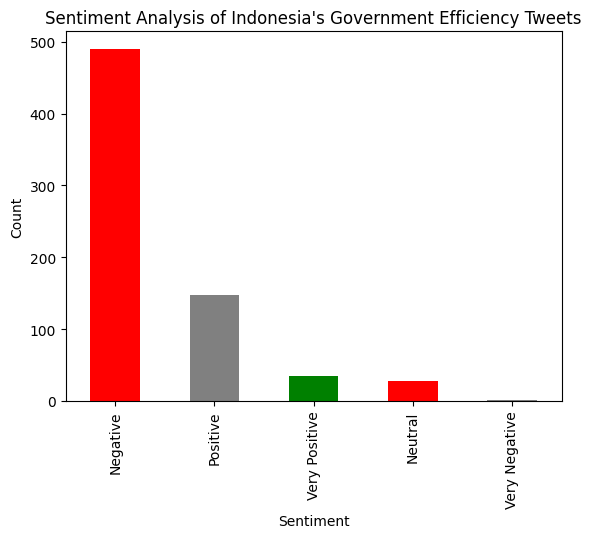

In [47]:
df_cleaned["sentiment"].value_counts().plot(kind="bar", color=["red", "gray", "green"])
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Sentiment Analysis of Indonesia's Government Efficiency Tweets")
plt.show()

In [ ]:
# tahap filtering penghapusan stopword pada data
# init stopword bahasa Indonesia
list_stopwords = stopwords.words('indonesian')

# inisialisasi fungsi filtering
# cek jika kata pada corpus ada pada dataset
# maka hapus kata tersebut
def filtering(words):
    return [word for word in words if word not in list_stopwords]
df['tweet_tokens_stopwords'] = df['tweet_normalisasi'].apply(filtering)
df

In [52]:
df

,tweet_cleaning
0,habis beli salad langganan tapi isinya ga penu...
1,Nanti kalo ada efisiensi lagi gausah diteriaki...
2,Jepang efisiensi Viral video doodstream indo p...
3,Pertamina makin serius dorong energi bersih Ka...
4,Yah rakyat dilupakan makanya prioritas nya bag...
...,...
734,Video Permintaan Tiket Penerbangan Turun Imbas...
735,Pemerintah tau ni kebijakannya jahat atau akan...
736,Legislator PKB menegaskan bahwa efisiensi angg...
737,Kebijakan Pemerintah untuk melakukan efisiensi...


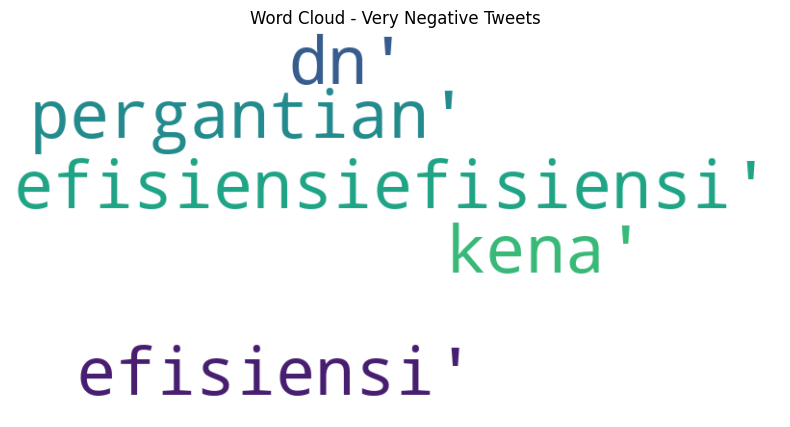

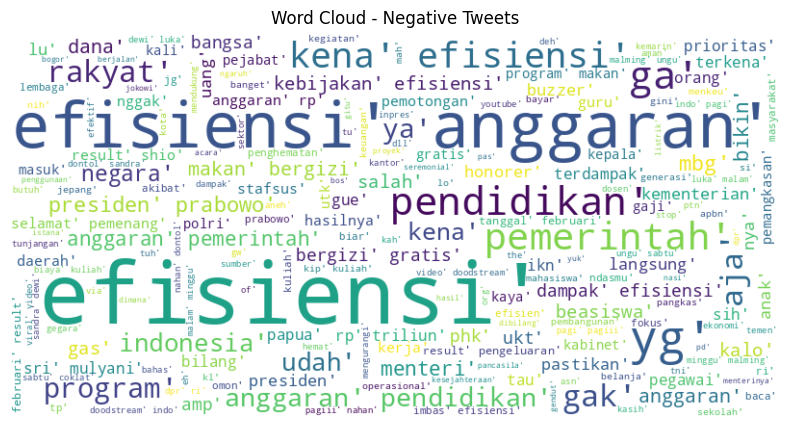

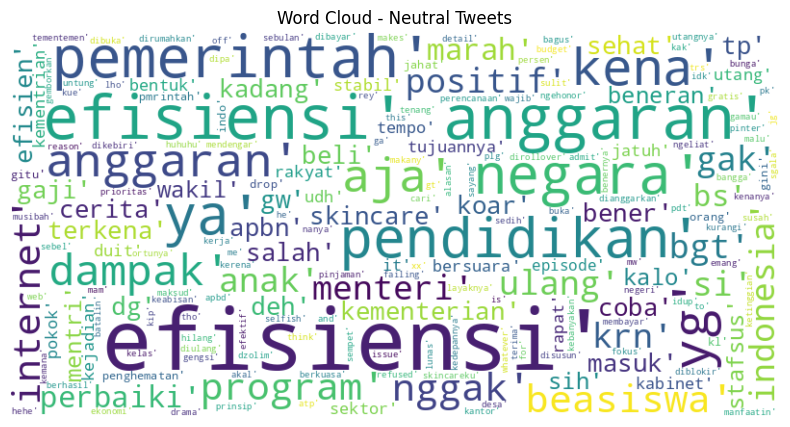

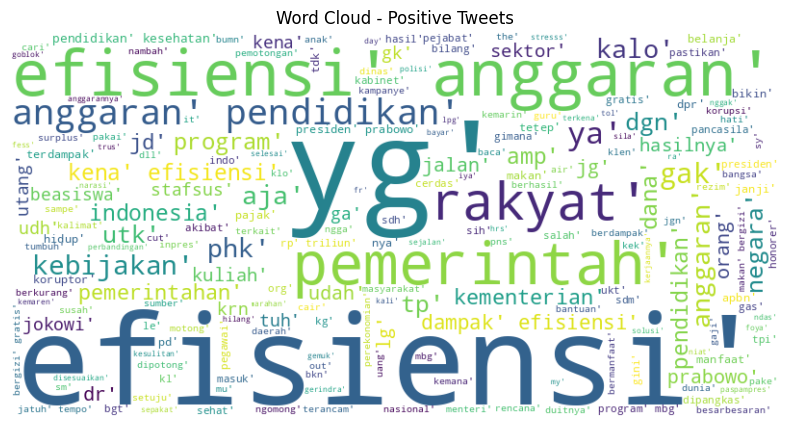

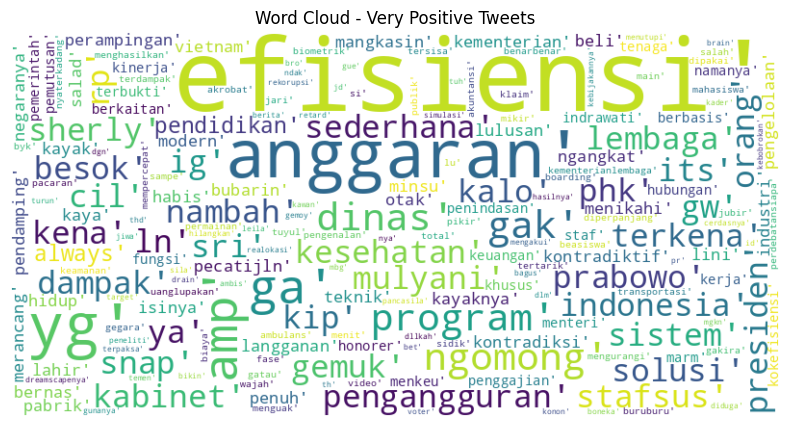

In [57]:
# Define the sentiment labels
sentiment_labels = ["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"]

for sentiment in sentiment_labels:
    # Ensure there are tweets for this sentiment before generating a word cloud
    sentiment_tweets = df_cleaned[df_cleaned["sentiment"] == sentiment]["tweet_tokens_stopwords"].dropna()

    if sentiment_tweets.empty:
        print(f"No tweets found for sentiment: {sentiment}")
        continue  # Skip to the next sentiment if no tweets are available

    # Convert the cleaned token list to a single string
    text = " ".join(sentiment_tweets.astype(str))

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud - {sentiment} Tweets")
    plt.show()

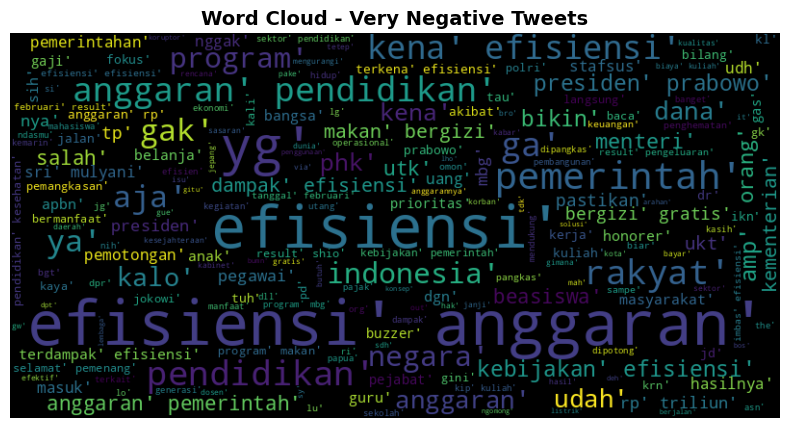

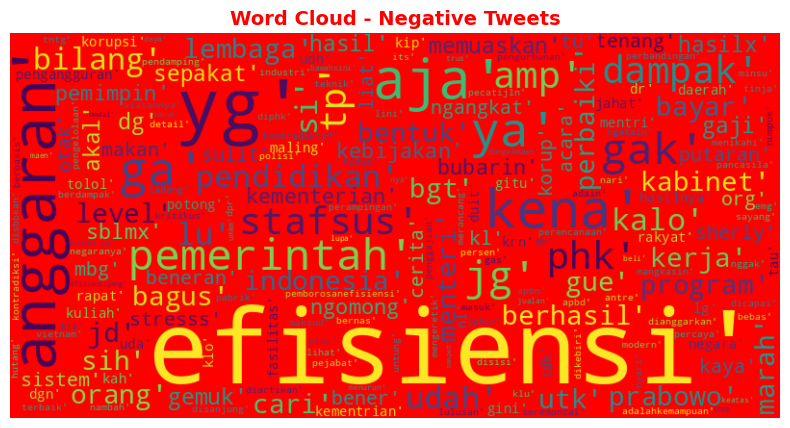

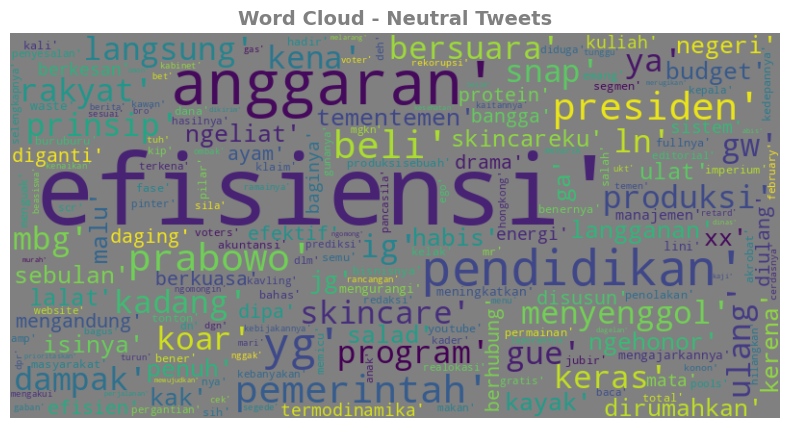

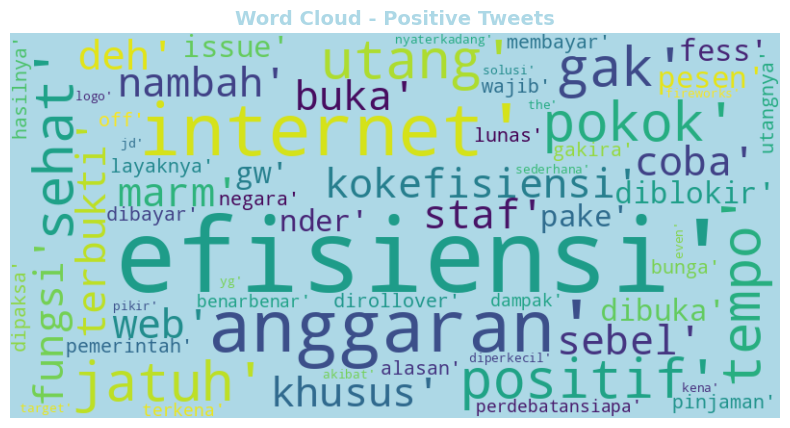

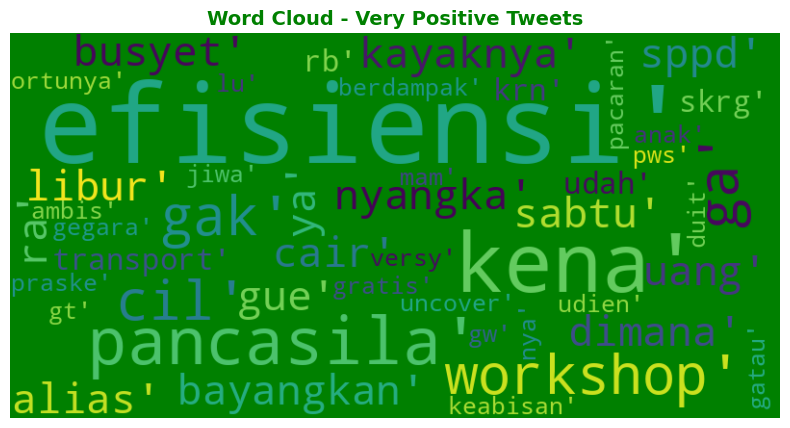

In [104]:
sentiment_colors = {
    "Very Negative": "black",
    "Negative": "red",
    "Neutral": "gray",
    "Positive": "lightblue",
    "Very Positive": "green"
}

for sentiment in sentiment_labels:
    sentiment_tweets = df_cleaned[df_cleaned["sentiment"] == sentiment]["tweet_tokens_stopwords"].dropna()

    if sentiment_tweets.empty:
        continue

    text = " ".join(sentiment_tweets.astype(str))

    # Generate word cloud with custom colors
    wordcloud = WordCloud(width=800, height=400, background_color=sentiment_colors.get(sentiment, "white")).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud - {sentiment} Tweets", fontsize=14, fontweight="bold", color=sentiment_colors[sentiment])
    plt.show()

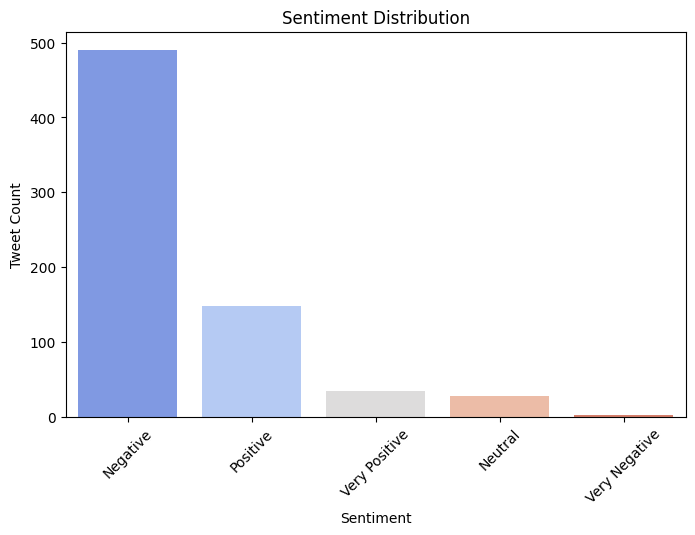

In [48]:
# Count tweets per sentiment
sentiment_counts = df_cleaned["sentiment"].value_counts()

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="coolwarm")
plt.xlabel("Sentiment")
plt.ylabel("Tweet Count")
plt.title("Sentiment Distribution")
plt.xticks(rotation=45)
plt.show()

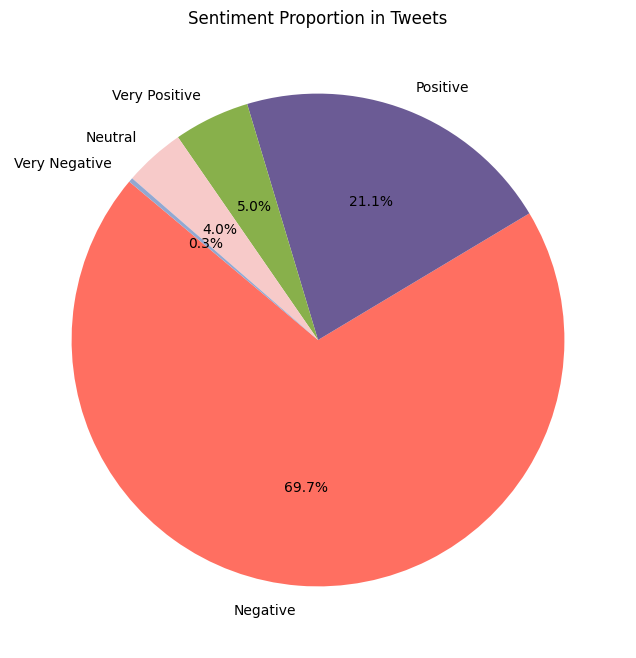

In [50]:
# Define a more fun and vibrant color palette
colors = ["#FF6F61", "#6B5B95", "#88B04B", "#F7CAC9", "#92A8D1"]

plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct="%1.1f%%", colors=colors, startangle=140)
plt.title("Sentiment Proportion in Tweets")
plt.show()

<ipython-input-112-e7d03ab2b676>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["cleaned_text"] = df_cleaned["tweet_tokens_stopwords"].astype(str)


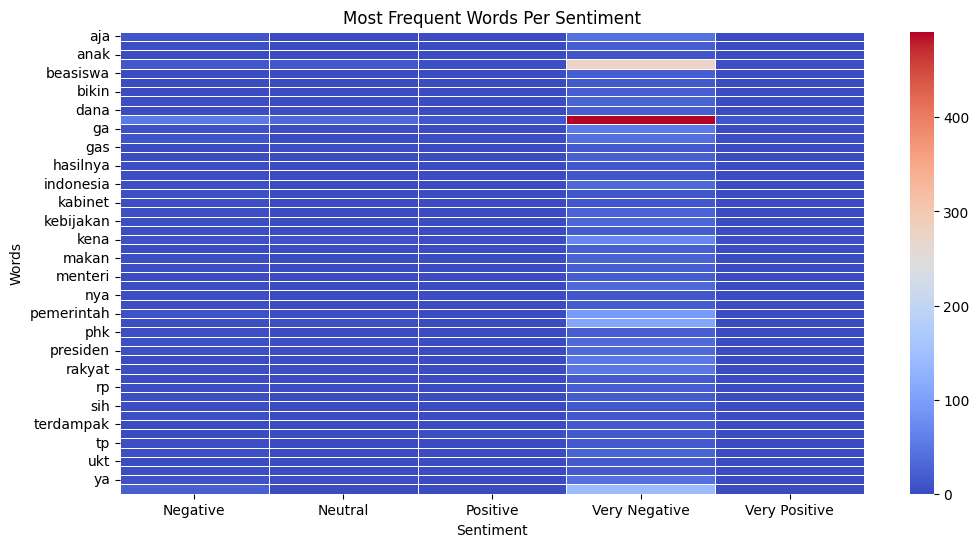

In [112]:
# Convert token lists into raw text
df_cleaned["cleaned_text"] = df_cleaned["tweet_tokens_stopwords"].astype(str)

# Vectorize words
vectorizer = CountVectorizer(stop_words="english", max_features=50)  # Top 50 words
X = vectorizer.fit_transform(df_cleaned["cleaned_text"])

# Convert to DataFrame
word_counts = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
word_counts["sentiment"] = df_cleaned["sentiment"]

# Group by sentiment and sum word counts
word_counts = word_counts.groupby("sentiment").sum()

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(word_counts.T, cmap="coolwarm", linewidths=0.5)
plt.xlabel("Sentiment")
plt.ylabel("Words")
plt.title("Most Frequent Words Per Sentiment")
plt.show()

In [115]:
# Prepare data
word_freq = word_counts.T.reset_index().melt(id_vars=["index"], var_name="Sentiment", value_name="Frequency")
word_freq.columns = ["Word", "Sentiment", "Frequency"]

# Bubble Chart
fig = px.scatter(word_freq, x="Sentiment", y="Word", size="Frequency", color="Sentiment",
                 title="Word Frequency by Sentiment", hover_name="Word", size_max=40)
fig.show()